In [35]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [36]:
# Input: cv2 image
# Output: binary image
# Remove backgroud; leave only gates
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.inRange(img, (0, 60, 20), (179, 255, 255))
    img = sides(img)

    return img

# Input: cv2 image
# Add black borders to the image
# Fill sides with partial gates with white to make them whole
def sides(img):
    img = cv2.copyMakeBorder(img, 100, 100, 100, 100, cv2.BORDER_CONSTANT, value=0)
    # Top
    if np.any(img[100:-101, 100]):
        img[:, :100] = 255
    # Bottom
    if np.any(img[100:-101, -101]):
        img[:, -101:] = 255
    # Left
    if np.any(img[100, 100:-101]):
        img[:100, :] = 255
    #Right
    if np.any(img[-101, 100:-101]):
        img[-101:, :] = 255
    
    return img

# Input: cv2 image
def find_largest_contour_with_child(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find contours with children
    cont_arr = []
    for i, cont in enumerate(contours):
        # Has children?
        if hierarchy[0, i, 2] > -1:
            cont_arr.append(cont)
    
    if len(cont_arr) == 0:
        return []

    # Calculate contour sizes
    sizes = []
    for cont in cont_arr:
        sizes.append(cv2.contourArea(cont))

    # Largest contour
    largest = cont_arr[np.argmax(sizes)]
    return largest

# Input: cv2 contour
# Test if contour is close enough to convex
def test_convexity(cont):
    
    hull = cv2.convexHull(cont,returnPoints = False)
    hull_points = cv2.convexHull(cont,returnPoints = True)
    defects = cv2.convexityDefects(cont,hull)
    convexity_threshold = 0.03 * cv2.arcLength(hull_points, closed=True)

    if  defects is None:
        return True
    
    # Approximate distance to farhest point from convex hull
    # More info: https://docs.opencv.org/4.x/d5/d45/tutorial_py_contours_more_functions.html
    farthest =  defects[:, :, 3]/256.0
    farthest = farthest.flatten()

    for dist in farthest:
        if dist > convexity_threshold:
            return False

    return True

# Input: (cv2) binary image
# Erode the image until the closest gate is separated from other gates
# and the pole is gone
def sep_closest_gate(img):
    # Erosion kernel
    kernel = np.ones((2,2),np.uint8)
    test_img = img.copy()

    index = 0
    # For loop instead of while to prevent looping too long
    for i in range(100):
        test_img = cv2.erode(test_img, kernel, iterations = 1)
        cont = find_largest_contour_with_child(test_img)

        # No contours with child left?
        if len(cont) == 0:
            index = i
            break
        elif test_convexity(cont):
            index = i + 1
            break
    
    # Erode the actual image one less time to keep the gate whole
    for i in range(index):
        img = cv2.erode(img, kernel, iterations = 1)
       
    return img


    
# Input: cv2 image
# Output: bounding rectangle of closest gate
def get_closest_gate(img):
    img = preprocess(img)
    img = sep_closest_gate(img)
    cont = find_largest_contour_with_child(img)
    x,y,w,h = cv2.boundingRect(cont)
    return x, y, w, h


554 314 156 304


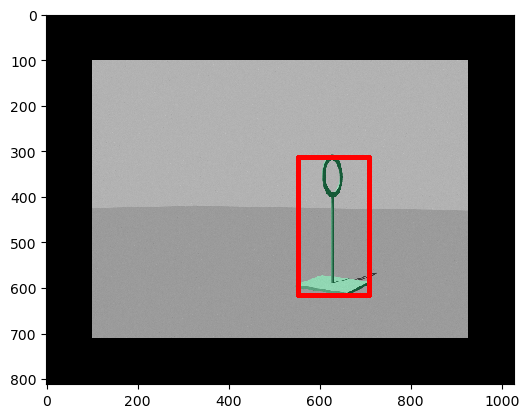

445 358 135 131


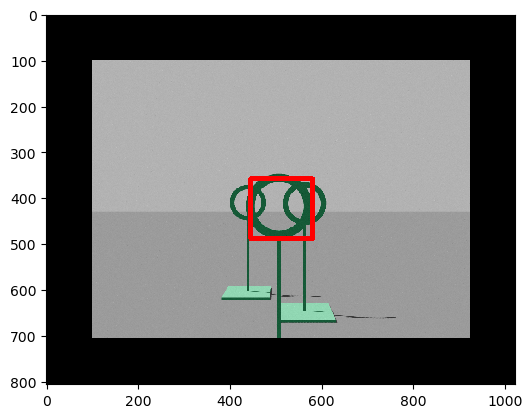

351 475 243 240


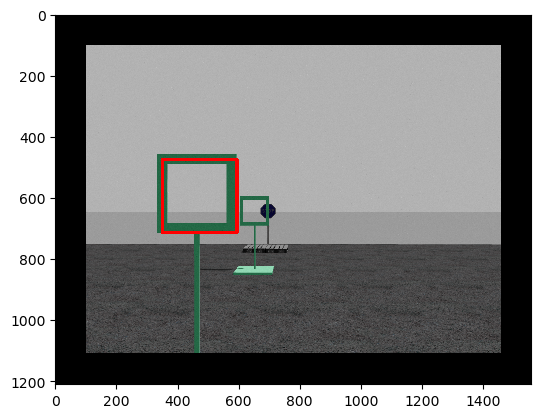

239 177 54 50


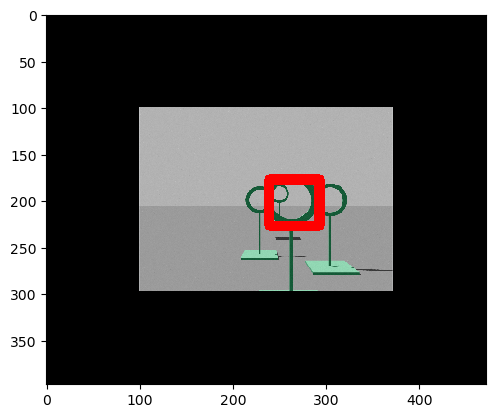

0 0 429 1212


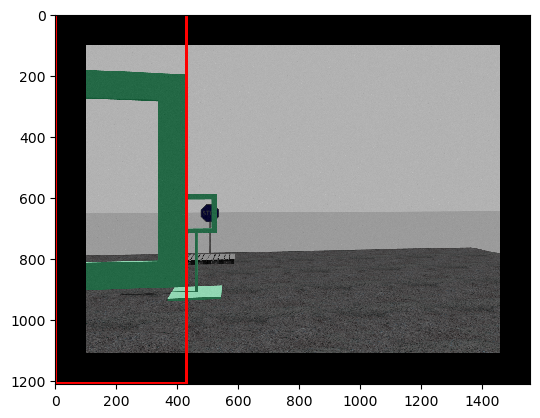

302 289 113 111


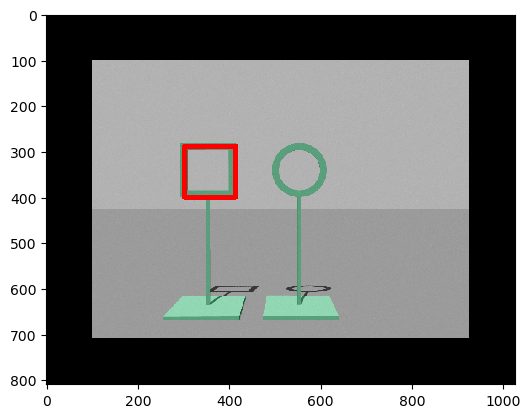

447 361 132 129


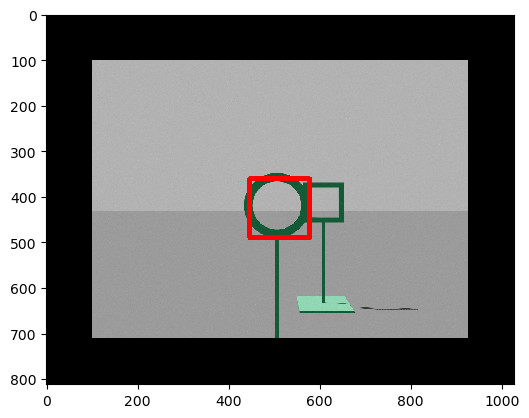

1307 466 51 127


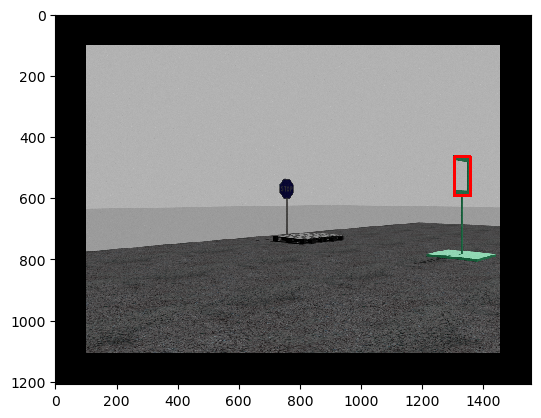

444 356 133 138


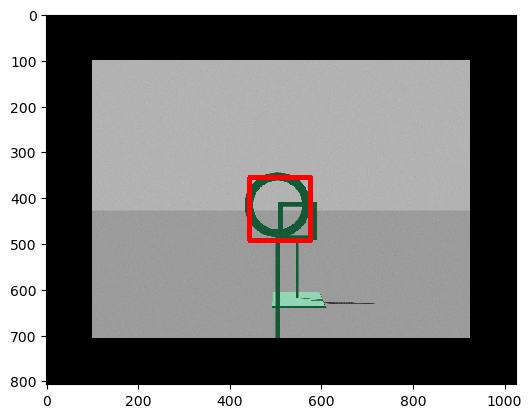

1233 565 39 39


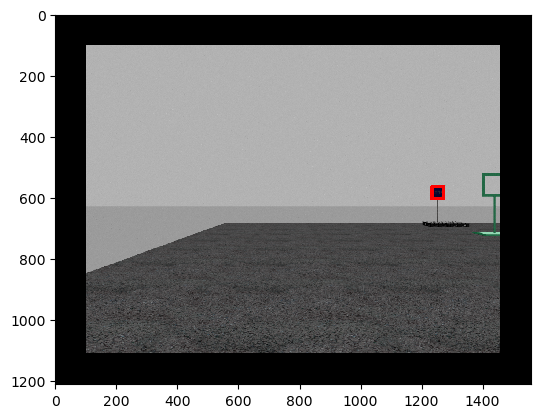

443 277 134 125


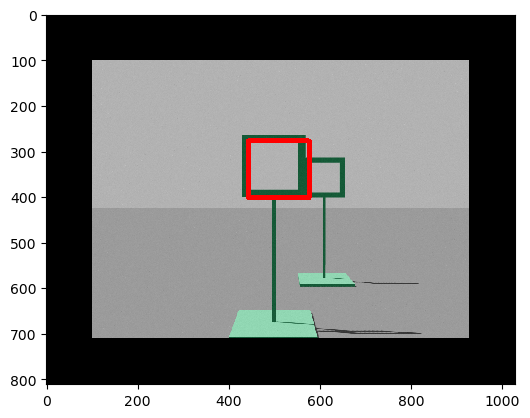

0 0 1541 876


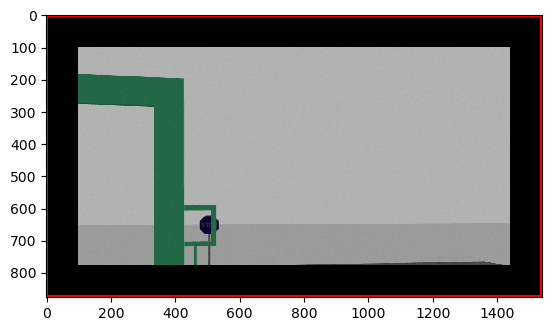

0 0 1556 1210


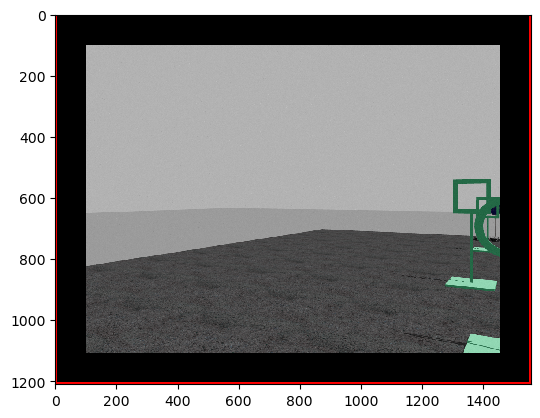

1154 566 118 257


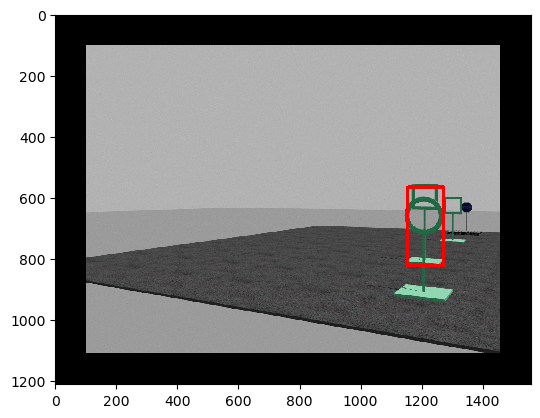

442 275 148 132


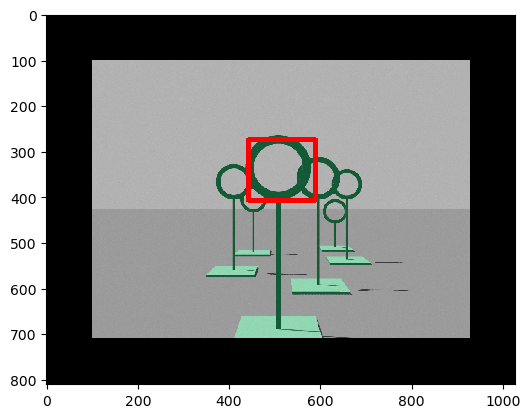

753 531 60 68


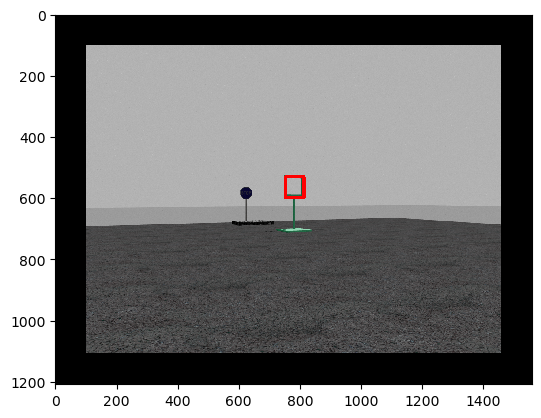

661 333 260 274


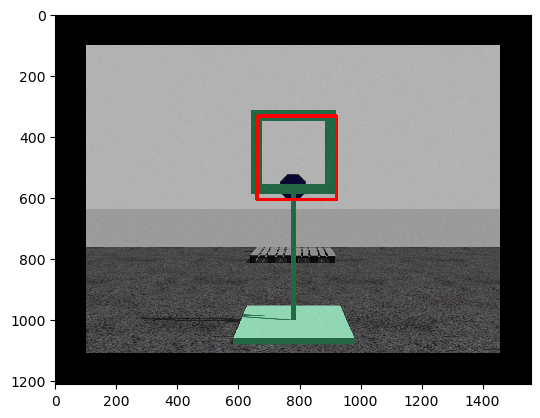

772 296 84 104


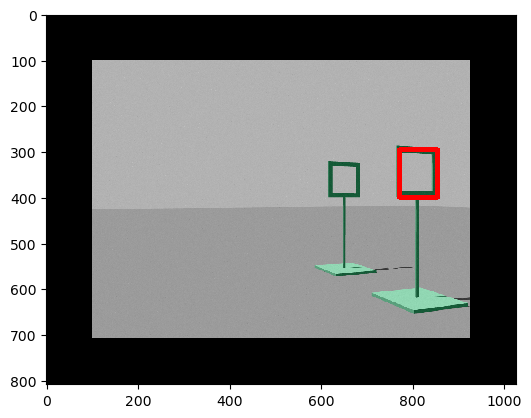

0 0 748 1212


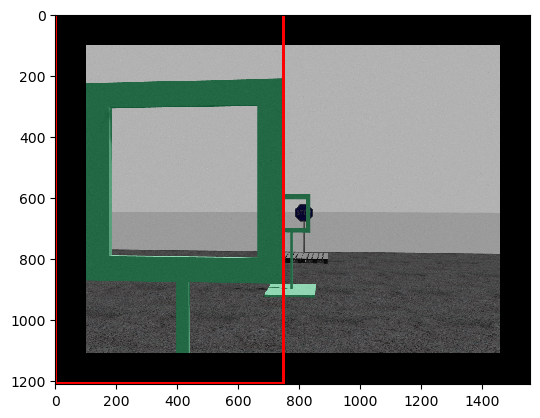

439 273 130 128


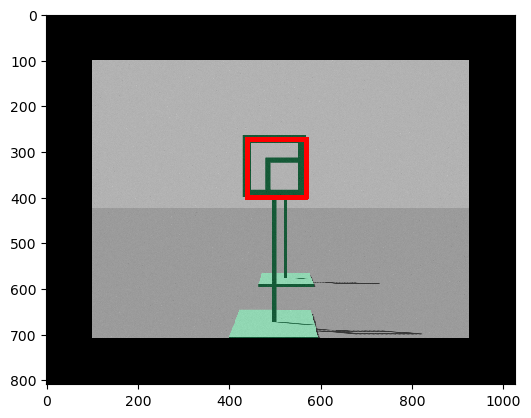

446 275 137 131


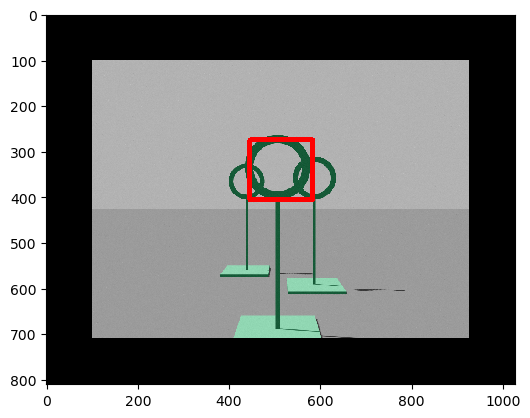

200 143 51 49


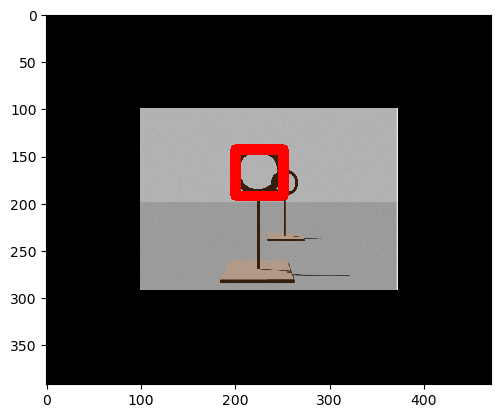

744 524 77 82


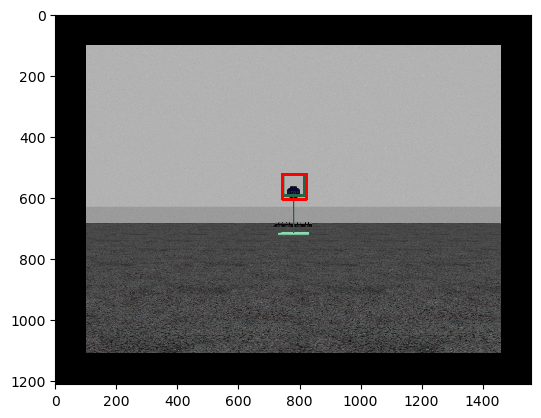

1141 488 201 213


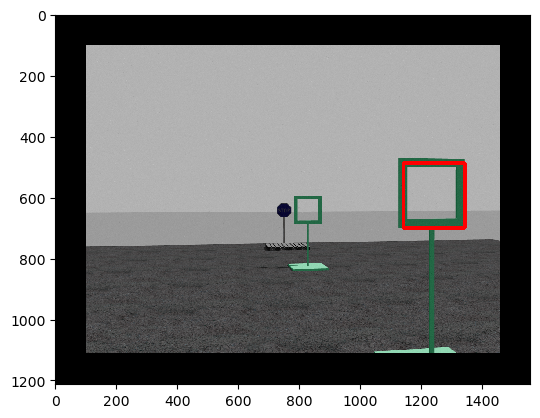

315 612 295 294


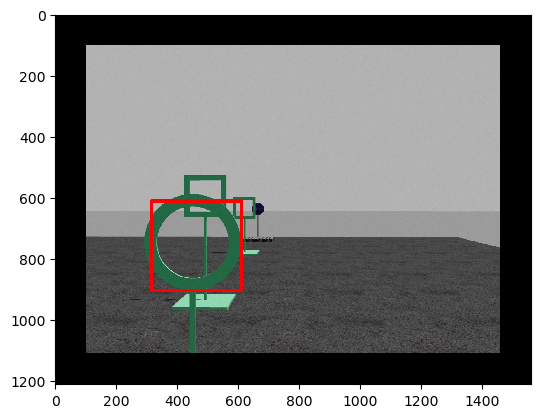

461 614 489 486


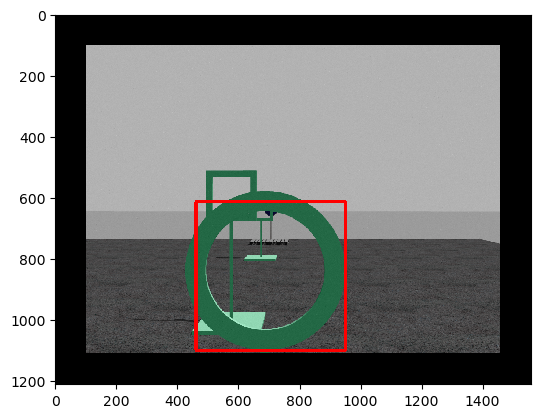

208 177 51 49


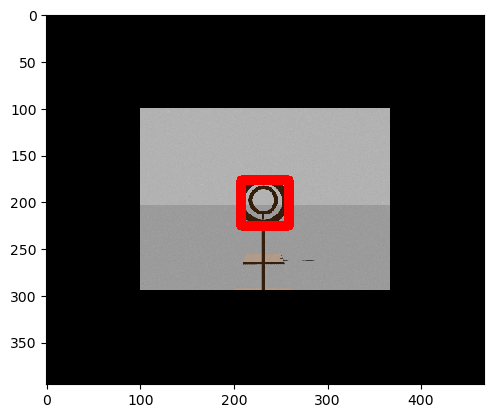

209 155 51 49


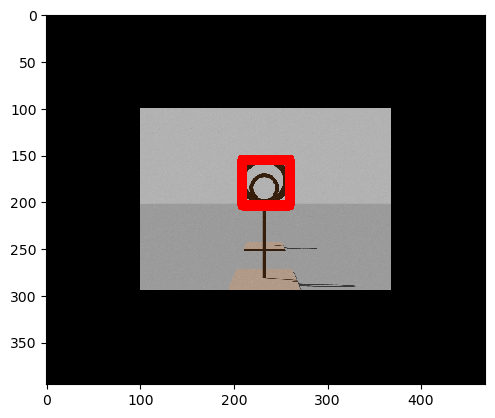

603 304 58 97


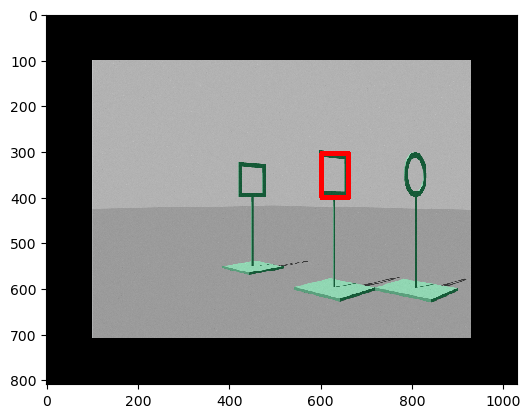

In [37]:
for filename in os.listdir('images'):
    f = os.path.join('images', filename)
    img = cv2.imread(f)
    x, y, w, h = get_closest_gate(img)
    img = cv2.copyMakeBorder(img, 100, 100, 100, 100, cv2.BORDER_CONSTANT, value=0)
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),10)
    print(x, y, w, h)
    plt.imshow(img)
    plt.show()

In [38]:
"""
for filename in os.listdir('images'):
    f = os.path.join('images', filename)
    img = cv2.imread(f)
    gates = preprocess(filename)
    closest_gate = sep_closest_gate2(gates)
    cont = largest_contour_with_child(closest_gate)
    x,y,w,h = cv2.boundingRect(cont)
    closest_gate = cv2.rectangle(closest_gate,(x,y),(x+w,y+h),(255,255,255),2)
    plt.imshow(img)
    plt.show()
    plt.imshow(closest_gate, cmap='gray')
    plt.show()
"""

"\nfor filename in os.listdir('images'):\n    f = os.path.join('images', filename)\n    img = cv2.imread(f)\n    gates = preprocess(filename)\n    closest_gate = sep_closest_gate2(gates)\n    cont = largest_contour_with_child(closest_gate)\n    x,y,w,h = cv2.boundingRect(cont)\n    closest_gate = cv2.rectangle(closest_gate,(x,y),(x+w,y+h),(255,255,255),2)\n    plt.imshow(img)\n    plt.show()\n    plt.imshow(closest_gate, cmap='gray')\n    plt.show()\n"